<a href="https://colab.research.google.com/github/paulodowd/EMATM0054_53/blob/main/Labsheets/Core/L1_Motors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Labsheet 2: Motors

This worksheet will cover getting your motors to move on your 3Pi+ robot.  In previous labsheets you will have:
 - Seen the standard Arduino sketch, which has the structure of setup() and loop() routines.
 - Experimented with Arduino Example sketches
 - Uploaded sketches to your robot.
 - Experimented with Serial commands to view debug output from your code.

In this labsheet we are going to:

- Get the 3Pi+ Motors moving.
- Utilise `pinMode()`, `analogWrite()` and `digitalWrite()`.

The motor control methods we develop in this labsheet are very basic.  Later, you can  implement better methods by looking at the <a href="https://colab.research.google.com/github/paulodowd/EMATM0054_53_23-24/blob/main/Labsheets/Core/L7_PID.ipynb">labsheet for PID</a>.  However, this labsheet is important to introduce you to the basic concepts.  For now, do not worry about "perfect" performance - instead, try to understand and quantify the performance you see.

To test any code you write for motors, you will need to enable the battery power on your 3Pi+.
- There is a small button labelled `Power` on the top of the 3Pi+.  Press once to turn on, and press once again to turn off.  
- When battery power is `on`, a blue LED light will shine next to the button.
- When you are not using the motors, you can increase the longevity of your batteries by turning battery power off.  
- Except motors, all other devices on the 3Pi+ can be used on USB power alone.  
- The 3Pi+ can be plugged into USB and use battery power simultaneously.

<p align="center">
<img width="50%" src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_BattPowerBtn.png?raw=true">
</p>

## Caution!

- The 3Pi+ can move very fast. Please read through the Risk Assessment available on Blackboard.
- Please be aware of your surroundings.  
- When you have an error in your code, your robot may suddenly move away.
- You can place your 3Pi+ on top of your reel of black tape whilst you are experimenting with the motors to lift it from the surface.  This will stop it from running away.
- In general, the maximum possible power (a value of 255) for the motors is not useful.  You want to program your robot to be under reliable control - so consider limiting this power value to begin with.
- Forcing a wheel to stop when it is being powered can cause **irreversible damage** to your 3Pi+.





<hr><br><br><br><br>

# 3Pi+ Motor Drivers

The 3Pi+ robot is controlled by an ATMEL ATMEGA32u4 Microcontroller (<a href="https://www.microchip.com/en-us/product/ATmega32U4">produce page</a>, <a href="https://ww1.microchip.com/downloads/en/DeviceDoc/Atmel-7766-8-bit-AVR-ATmega16U4-32U4_Datasheet.pdf">datasheet</a>).  We can think of a microcontroller as a computer which interacts with the external world (any connected peripherals) through `general purpose input/output` pins (GPIO pins) - the small metal tabs or legs around the actual microchip.  We can write a program (software) to tell the microcontroller to activate a pin `HIGH`, which provides a small amount of current (typically, 25 milliamps).  However, the voltage and current provided by the microcontroller is not enough to drive (activate) the motors of the 3Pi+.  

We can look at the schematic of the 3Pi+ (<a href="https://www.pololu.com/file/0J1790/3pi-plus-32u4-control-board-schematic.pdf">aviailable here</a>) to investigate how the motors can be driven.

<p align="center">
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_schematic_drv8838.png?raw=true">
</p>

In the above circuit schematic extract (found on page 2 of the linked document above), we can see the circuit symbol for the left and right motors (the blue circle on top of a blue box).  These are then attached to the integrated circuit (a microchip, the yellow box) labelled `DRV8838`, one for the left motor and one for the right motor.  

Each motor is electronically driven by a DRV8838, a low-voltage H-Bridge driver (a datasheet is available <a href="https://www.ti.com/lit/ds/symlink/drv8838.pdf?ts=1626947113238&ref_url=https%253A%252F%252Fwww.ti.com%252Fproduct%252FDRV8838">here</a>).  A <a href="https://en.wikipedia.org/wiki/H-bridge">H-Bridge</a> is a type of circuit which allows DC motors to be driven either forwards or backwards without needing to physically change the polarity of the connections to the DC motor.  

The fine black lines extending out of the yellow block indicate necessary connections to the DRV8838:  
- The DRV8838 is able to source (provide) more voltage and current through the connection labelled `VM` ("voltage-motors"), which is an alternative power supply.  This provides an independent power supply for the motors.
- The connection labelled `5V` provides a stable voltage supply for the digital logic of the DRV8838 circuit.  
- The DRV8838 has to be connected to ground (0v) to complete the electronic circuit, marked by the symbol which looks like a triangle of horizontal lines.  
- The labels `OUT1` and `OUT2` are attached to the DC motor.  By making one output `HIGH` and other `LOW`, the motor is driven forwards or backwards.
- We can observe that both the DRV8838 have connections labelled `PH` and `EN`:
  - Note: `PH` and `EN` appear to have an arrow indicated into them, but the lines are not terminated against a symbol.  This means they connect to another part of the circuit, drawn elsewhere.  
  - The red labels `D16`, `D10`, `D15`, `D9` can be found elsewhere in the document, which is their corresponding connection.  These are connections to our 32u4 microcontroller.
  - We can confirm these connections against the <a href="https://www.pololu.com/docs/0J83/5.9">pin assignment section of the documentation</a> (look for functions relating to motor).

The 3PI+ DRV8838 therefore have just two input signals each for their operation:

- The **`PH`** pin of the DRV8838 sets the **`direction`** of rotation of the motor of the 3Pi+.  In the pin assigment documentation, this is referred to as "left/right motor direction".

- The **`EN`** pin of the DRV8838 `enables` the motors.  When `EN` is set `LOW`, the motors are `not active`.  When `EN` is set `HIGH`, the motors are driven from the power supply `VM`.  In order to achieve different rotation speeds, `EN` is switched on-and-off very quickly.  In the pin assigment documentation, this is referred to as "left/right motor PWM".

`PWM` stands for Pulse Width Modulation.  Pulse Width Modulation means turning a digital signal either `HIGH` or `LOW` (`ON` or `OFF`) within a fixed period of time, and adjusting the timing interval of the signal.  This is often referred to as a `mark-to-space ratio`, because of the way the output signal appears, which forms the `duty-cycle` in %:

<p align="center">
<img width="50%" src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/PWM.png?raw=true">
</p>

In the above, we can see that at a 50% duty cycle, the signal has clear and equal on-periods and off-periods, or marks and spaces respectively.  When this PWM signal is measured by the microcontroller, it is effectively averaged over time.  Therefore, a PWM with a 50% duty cycle will be measured as 2.5volts. When we instruct a microcontroller to generate PWM, we are crudely synthesising an analog signal (continuous range) from a digital signal (binary range), which is often referred to as `DAC` - digital-to-analog conversion.  The DRV8838 receives the PWM output from the 32u4 microcontroller and will effect different motor power levels.  

The DRV8838 makes operating the motors very easy, we simply set a **`PWM`** level (power), and a **`direction`**.  The 3Pi+ is a **`differential drive`** robot from Pololu. This means it has two wheels as **`effectors`**, placed symmetrically either side of the longitude of the robot, to manoeuvre the robot.  Each wheel is driven by a motor each, the **`actuators`**.  
- To make the 3Pi+ move forwards or backwards the motors can be activated with the same **`PWM`** levels, set in the same **`direction`**.  
- The 3Pi+ can be made to move on an **`arc`** by activating the motors at different **`PWM`** levels, in the same **`direction`**.
- The 3Pi+ can be made to rotate on the spot by activating the motors at the same **`PWM`** levels, in different **`directions`**.

Conveniently, most microcontrollers contain dedicated hardware to generate PWM signals - meaning it is not necessary to write our own software routine to do so.  Within the Arduino programming environment, a function called **`analogWrite()`** performs this operation (<a href="https://www.arduino.cc/reference/en/language/functions/analog-io/analogwrite/">Arduino Reference</a>).  Writing a value of 255 creates a constant high signal (5v), whilst writing a 0 creates a constant low signal (0v).  Values between 0 and 255 generate square waveforms with a ratio of high (5v) and low (0v).  

It is important to note that when we set a `PWM` level as input to the DRV8838, we are setting a desired output power level but **not** speed.  **Speed** (or velocity) is a measurement, and currently we do not know the real rotation of the wheel during a period of time.  Imagine, we could set an output PWM duty cycle of 100%, but the DC motor could be broken - a measured speed of 0.



## Exercise 1: Basic Motor Operation

1. **Hypothesise (hardware):** In the above circuit extract, we can see a tiny arrow next to the symbol for the motors.  This arrow indicates the normal direction of the motor.  These arrows are pointing in different directions.  Why may the circuit and hardware have been specified in this way?

2. Follow the below code below these exercises, filling in the important parameters and operations:
 - you can find the appropriate pins in the <a href="https://www.pololu.com/docs/0J83/5.9">pin assignment section of the 3Pi+ documentation</a>.  
 - you will haved used the Arduino built-in functions to configure pins in Labsheet 1 (`pinMode()`)

3. **Validate:** Check that you have assigned the left and right pins appropriately.  Does activating just the left motor in code activate the left motor in reality?  What about the right motor, is that correct?

4. **Validate:** Check whether a `HIGH` value for the `direction` pin produces forward or backward motion of your robot.
  - It is recommended you then create and use `#define FWD LOW` (or HIGH), and `#define REV ...` definitions in your code, to make it more readable.  You can then use `FWD` and `REV` instead of `HIGH` and `LOW`, where `#define` is acting like a find-and-replace operation.

5. Explore combinations of left and right motor power values.  Adjust your program in simple ways to get your robot to:
  - drive forwards in a straight line.
  - drive backwards in a straight line.
  - turn on the spot to the left.
  - turn on the spot to he right.
  - drive on an arc, or to trace a large circle.
  - **Note:** When we are powering the motors and not using any sensor information, **your robot cannot drive in a good straight line**.  We will address this by programming line following behaviour, and later PID speed control.

6. Investigate how `analogWrite()` operates, and how it might produce errors:
  - What happens if you send negative numbers to `analogWrite()`?
  - What happens if a value larger than 255 is sent to `analogWrite()`?
  - What happens if fractional numbers are sent to `analogWrite()`?


```c

// Replace the ? with correct pin numbers
// https://www.pololu.com/docs/0J83/5.9
#define L_PWM_PIN ?
#define L_DIR_PIN ?
#define R_PWM_PIN ?
#define R_DIR_PIN ?

#define FWD ?
#define REV ?

// Runs once.
void setup() {

  // Set all the motor pins as outputs.
  // There are 4 pins in total to set.
  // ...

  // Set initial direction (HIGH/LOW)
  // for the direction pins.
  // ...

  // Set initial power values for the PWM
  // Pins.
  // ...


  // Start serial, send debug text.
  Serial.begin(9600);
  delay(1000);
  Serial.println("***RESET***");

}

// Repeats.
void loop() {

  // Add code to set the direction of rotation
  // for the left and right motor here.


  // Use analogWrite() to set the power to the
  // motors.
  // 20 is a low level of activation to test
  // the motor operation.
  analogWrite( L_PWM_PIN, 20 );
  analogWrite( R_PWM_PIN, 20 );

  // An empty loop can block further uploads.
  // A small delay to prevent this for now.
  delay(5);
}
```


<hr><br><br><br><br>



## Exercise 2: Getting Familiar

Although we are writing software, it is important that you learn from experience how your robot physically behaves under certain conditions.  Take some time to experiment with your code and figure out the limitations and surprises:

1. Deadband: The forward and reverse PWM values and which cannot produce movement are called a **deadband**, and can be a difficult problem to deal with when controlling motors.  What is the range of PWM values which constitute the deadband for your robot?
  - **Experimental Observations:** the following observations will be _unique to your 3Pi+_ and will be useful for future labsheets:
    - Experiment to find the **minimum** motor PWM required for your robot to move fowards, note this down.
    - Experiment to find the **minimum** motor PWM required for your robot to move backwards, note this down.
    - Are the above measurements the same values for forwards and backwards?
    - Are the above measurements the same for left and right motors?
    - **Hypothesise**: What factors (robot or environment) may influence your above observations?
      - which factors could you predict and test immediately?
      - which factors might take a long time to emmerge?
      - when you make these predictions, what do you hypothesise would be observable in the robot performance?

2. Drift: Because of varying tolerances in manufacturing, it is unlikely that you 3Pi+ motors will perform in an identical way.  We can evaluate this by observing the travel of the robot against a straight line.  Use the black vinyl tape to mark down a straight line on your work surface (or draw a line). A recommended minimum distance is **60cm**.  Adjust your Arduino program in the following ways:
  - Set the same direction for both motors and set the same PWM value for left and right motors.
  - Set your program so that your robot will drive forwards for a fixed period of time, enough to travel the length of your line.  You can use `delay()` for this.  Your robot should then deactivate the motors indefinitely (until power-cycled or reset is pressed - see note below for help).  
  - Use tape or draw some marks on the work surface so that you can start your robot in the same location and rotation precisely.  If you cannot place your robot consistently, you will introduce **`human error`** into your experiment, and **`confuse`** your results.  
  - **Experimental Observations:**
    - Activate your robot and allow it to complete the forward travel.
    - Decide how to mark the end position of the robot.  We want to measure the the distance between the center of the robot and the center of the straight line.
    - Repeat this process 10 times for a single PWM value, recording your results.  
    - Use the code cell below (or other software) to plot your results.  Try using a different PWM value to measure the error over the same distance.  Record your results, plot them.
    - How can we interpret, or what can we learn, from the Box and Whisker plot?
    - what would a negative Travel Error (mm) indicate, versus a positive value?
    - **Hypothesise:** If all results were negative, how would you predict and explain what this meant in terms of the **`observable behaviour`** of your robot?
    - In the boxplot, what does the size of the box represent?
    - Are we observing **random error**, or **systematic error**?  Which of these is **evidenced** in the graph of your results, and how?


**Note**: to halt your robot motion indefinitely (stop travelling), you will need to write a 0 PWM value to both motors, and then trap your program within a loop with no end.  The following code extract is an example:
```c
  // Example to stop the robot indefinitely.
  // Only a hard reset will break the loop.
  analogWrite( L_PWM_PIN, 0);
  analogWrite( R_PWM_PIN, 0);
  while(1) {
    Serial.println("Program Halted");
    delay(500);
  }
```

### Graphing Example: Box-and-Whisker Plot

The following YouTube video provides a clear description of how a box-and-whisker plot is made: <a href="https://www.youtube.com/watch?v=fJZv9YeQ-qQ">Boxplots Explained!</a>

The following YouTube video provides a good discussion of how to read a box-and-whisker plot: <a href="https://www.youtube.com/watch?v=7fJpVQfeq4s">How to Interpret a Box and Whisker Plot - Sheaff Math</a>

Whilst the below python code looks complicated, it is worthwhile becoming familiar with how to plot graphs this way as it will produce some of the best communication of results for Assessment 2.

[Text(0, 0.5, 'Travel Error (mm)'),
 Text(0.5, 0, 'PWM Value'),
 Text(0.5, 1.0, 'Fictional Results')]

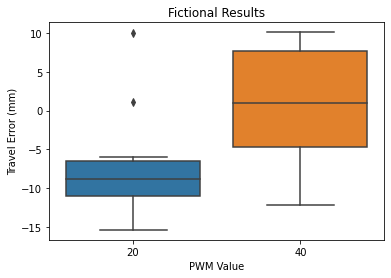

In [ ]:
#
# An example of using Python, Seaborn and
# Pandas to plot data into a Boxplot.

# We will use a library called Seaborn to
# make our box plot for us, so we import it.
import seaborn as sns


# To graph more than one dataset is a little
# complicated.  We need to format the
# data into 'dataframes'.  We use the pandas
# library to do this for us.  Import pandas:
import pandas as pd

# Add your measurements into the arrays
# like the following.
# Here, these are distance between the
# 3Pi+ center and the line center.
pwm_20 = [-9.1, -12.4, -8.6, -10.3, -15.4, -11.2, 10.0, -6.0, -8.1, 1.1]
pwm_40 = [-12.2, 10.1, 8.1, -8.2, 0.2, 8.5, -6.4, 6.2, 1.1, 0.8]

# You can make further arrays, following the
# pattern:
# pwm_60 = [ , , , ]

# We use the .DataFrame() function to apply a
# label to each array of results
pwm_20_dataframe = pd.DataFrame({'20':pwm_20})
pwm_40_dataframe = pd.DataFrame({'40':pwm_40})
# pwm_60_dataframe = pd.DataFrame({'60':pwm_60})

# We then add the two dataframes together.
combined = pd.concat([ pwm_20_dataframe, pwm_40_dataframe], axis=0)
# combined = pd.concat([ pwm_20_dataframe, pwm_40_dataframe, pwm_60_dataframe], axis=0)

# We can now plot both datasets at the same time.
# Note, data=combined!
plot = sns.boxplot(data=combined)
plot.set(xlabel ="PWM Value", ylabel = "Travel Error (mm)", title ='Fictional Results')

<hr><br><br><br><br>


## Exercise 3: Confident Operation

A robotic system can quickly become very complicated, and it can be hard to tell where an error is coming from.  Sources or causes of error in a robotic system include:
- **Environment:** misunderstood or unanticipated environment conditions (e.g. a dirty floor, bright sunlinght)
- **Hardware:** mechanical, electronic failures on the robot (e.g. something not plugged in, low battery power).
- **Software:** logical and/or execution programming errors (e.g. a bug in your code!).
- **Task:** human misunderstanding of the robot capability or assigned task (e.g. <a href="https://en.wikipedia.org/wiki/Anthropomorphism">anthropomorphism</a>, "it should know...!").

As a rule of thumb, it is good practice to move through the above 4 categories when attempting to diagnose a problem.  Usually, we become very focused at the  **task** and **software** level, and we typically can overlook errors caused by the **hardware** and **environment** (such as, a dirty worksurface changing the behaviour of the robot).  Because of this, we can spend hours editing a lot of code from an assumption of a problem.

To make problem solving easier, we can prioritise being **confident** that our code works as expected.  If we can catch all possible error conditions in software, we will have an easier time figuring out why something isn't working.  

1. **Refactor:** Complete the below example function to operate your 3Pi+ motors.
  - Focus on either the left or right motor first.
  - Use the sign of the argument `PWM` to set the motor direction.
  - Use the absolute magnitude (unsigned value) of argument `PWM` for analogWrite().
  - Limit the possible range of values accepted.  What is a sensible range?
    - **Note:** This means setting a maximum speed, both forwards and backwards. This is highly recommended.
  - Decide how your function should respond to illegal values.
  - When satisfied that one motor is working correctly, complete the function to work with both motors.


```c
/*
 * Sets the power of the motors using analogWrite().
 * This function sets direction and PWM (power).
 * This function catches all errors of input PWM.
 *  inputs:
 *     pwm   accepts negative, 0 and positve
 *           values.  Sign of value used to set
 *           the direction of the motor.  Values
 *           are limited in range [ ??? : ??? ].
 *           Magnitude used to set analogWrite().
 */
void setMotorPower( float left_pwm, float right_pwm ) {

}
```

2. **Validate:** Write a test routine within your main `loop()`:
  - Start your PWM value at 0
  - Write a routine to automatically increment the value sent to your motor operation function.  
  - Allow the value to increment past the acceptable input to your motor operation function.  What should happen, as determined in your function?
  - Set an arbitrary positive limit witin `loop()`, which once reached toggles the routine to decrement into negative PWM values.  What should happen, as determined in your function?
  - Allow the negative values to exceed the valid input range of your function.  What should happen?
  - Conduct this test on left and right motors simultaneously.
  - Did your code and robot pass the test?


<hr><br><br><br><br>

# Classes in Arduino

Operating the 3Pi+ motors provides a good opportunity to introduce `classes` in the Arduino Environment.  Currently, we have three essential components for our motors, which are spread out in our code:

1. The pin definitions, and possibly other mnemonics, defined in `global scope`.
2. Setup instructions for the motor gpio pins, contained within `setup()`
2. Commands for the motors, encapsulated within a function somewhere in our source file.

A `class` provides a way to group variables and functions neatly within a single encapsulation, to then be referenced elsewhere.  This will significantly improve the readability of your code, and your ability to transfer functionality between revisions or projects.  Instead of looking for the functionality somewhere in your code, you will be able to turn to the class file.  Classes also have other benefits, which will become apparent as we move through these labsheets.

```c
#include "motors.h"

Motor_c motors;

void setup() {

  // Setup motor pins
  motors.init();
}

void loop() {

  // Set both motors power.
  motors.setMotorPower( -100, 100 );

  delay(100);

}
```

The above code extract provides a minimal example of a class being used.  The top line:
```c
#include "motors.h"
```

allows external additional files of code to be included in your project.  In this case, the file must be called "motors.h", and it must be located within the same folder as your current sketch file (.ino).  If you have some exeprience with C or Arduino, you might find it unusual to only use a `.h` file (and not further `.c` or `.cpp` files).  Here, we have made decision to simplify matters for teaching and ease of learning, and so just use `.h` files.  

On Windows, you can create a blank text file, and rename the extension to ".h".  You may need to change folder options within Explorer to make file extensions visible.  For these labsheets, you can download a template Arduino sketch with empty suggested class files created for you from Github (<a href="https://github.com/paulodowd/EMATM0054_22-23/tree/main/3PI_CodeStub">Github Page</a>, <a href="https://github.com/paulodowd/EMATM0054_22-23/blob/main/3PI_CodeStub/Labsheet_X.zip">Download Link for Zip file</a>).

The line:
```c
   Motor_c motors;
```

should look familiar, as if it is a `variable declaration` in `global scope`.  In many ways it is.  When a class is used to group together variables and functions, we can imagine it will effectively be used as a template to reserve computer memory - like a variable.  You can think of a class as a named container for variables and functions.  In this case, `Motor_c` is the `data type`, and `motors` is the name we will use to access this instance. This is like `int my_int`, which creates a place to store signed whole numbers named `my_int`.  In the same way we use variables, we could declare many instances of the class (data type) Motor_c like:

```c
Motors_c motors_1;
Motors_c motors_2;
Motors_c motors_3;
Motors_c motors_4;
```

This would mean that each instance would get an exclusive copy of everything contained inside the class - the variables and functions.  So this is a useful way to keep data grouped together by context, and to replicate functions so they operate consistently on the data.

The line:
```c
   motors.init();
```

demonstrates how we can "look inside" or access the inner-content of our class (the variables and functions).  When we see a name followed by a dot `.`, we can understand that we are accessing the internal structure of a class, and that this makes it different from a normal variable.  In this case, after the dot `.` we see `init();`, which looks like a function call, because it is.  We can read this line of code as
> execute the function named `init()` within `motors`

The same pattern is followed with the line of code inside `loop()`:

```c
   motors.setMotorPower( -100, 100);
```

Again, we can read this as:
> execute the function named `setMotorPower()` within `motors`, and provide the values `-100` and `100` into the function.

We can use class functions in the same ways we use ordinary functions - the following examples are valid and would work, if the underlying code for the functions exist within the class:

```c
int my_int;

// getMotorPower() would return an int.
my_int = motors.getMotorPower();

// We can also pass arguments in
motors.setMotorPower( -100, 100 );

```

At this point, a good question is:
> How can we know what exists to use inside a class, or how to use it?

One answer to this question is to look at either the source code or the documentation.  You have already been using a class when calling `Serial.print()` and `Serial.println()`, and more functions you can access of Serial (after the dot `.`) are documented in the <a href="https://www.arduino.cc/reference/en/language/functions/communication/serial/">Arduino Reference</a>.

In our case, we are going to write a class to encapuslate our motor operation code.  Therefore, we are in control of defining the what and how.  A class has the following essential and necessary minimum structure within Arduino:

```c
// Class keyword, followed by the assigned
// data type "Motor_c".
// This is what we will later use to declare
// instances of our class datatype.
class Motors_c {

  // This keyword means that all code
  // below this point is accesible from
  // outside the class.
  public:

    // A class must have a special function
    // called a "constructor".  This function
    // must be named the same as the data type
    // in this case, Motor_c.  Note, there is
    // no return type, and this is how you know
    // this is the special constructor function.
    Motors_c() {

    }

    // A function to operate the motors and stop
    // any errors in use.
    void setMotorPower( float l_pwm, float r_pwm) {

    }

}; // This curly-brace and semi-colon
   // finishes the content of our class.
```

The above is an example of a minimum class definition, and presently it "contains" no real code, and so "does nothing".  It is worthwhile remembering this as the "template" of a class - you will see this general form often if you continue with Arduino.

After this, we can add our own code for variables and functions.  You can regard the outer-most encapsulation (between the curly-braces, `class Motor_c { ... }`) to behave as the Sketch file you are used to.  Therefore, scope applies in the following ways:

```c
class Motors_c {

  // This keyword means that all code
  // below this point is accesible from
  // outside the class.
  public:

    // These variables are "global" within the
    // class, meaning any part of the class can
    // access them.  Note, they are not global
    // from elsewhere in your Arduino program.
    // These variables will be persistent, and
    // so keep their assigned value between
    // class access operations (with the .)
    int my_int;
    float my_float;

    // Constructor, it always needs to exist
    Motors_c() {

    }

    // Functions must be defined in the global
    // scope of the class.  E.g. you cannot
    // create a function inside a function.
    void myFirstFunction() {

      // This is a variable declared inside
      // this function.  That means it has
      // local scope to this function. So, it
      // cannot be accessed outside this
      // function, and it will also be deleted
      // when the function ends.
      int my_local_int;

      // You can write other code
      // ...

    }

    // You can create lots of functions, and you
    // can define them in ordinary ways to include
    // return types and arguments
    int anotherFunction( int a, float b, char c) {      
      
        // You can utilse a,b,c here in normal
        // ways.

        // You can also call a class function from
        // within a class, and you don't need the
        // dot, because it is local to the class.
        myFirstFunction();
   
        return 0;
    }

}; // This curly-brace finishes the content of our class.

```

When you have defined your class, you can then declare instances of it (like a variable) and then access and using the named instance.  Using the class definition immediately above, we can demonstrate a few other minor operations:

```c

// Create an instance of the class
Motor_c motors;

// As well as functions, you can
// access the variables inside
// the class directly using the .
void loop() {

  // Write to a top-level class
  // variable.  Just like normal,
  // you cannot read or write to
  // variables inside functions.
  motors.my_int = 1;

  // Read from a top-level class
  // variable.
  float test = motors.my_float;

}
```




## Exercise 4: Write and Test a Motor Class

You can download a template Arduino sketch with empty class files created for you from Github (<a href="https://github.com/paulodowd/EMATM0054_53_23-24/tree/main/3PI_CodeStub">Github Page</a>, <a href="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/3PI_CodeStub/Labsheet_X.zip">Download Link for Zip file</a>).

<p align="center">
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_ArduinoTabs.png?raw=true">
</p>

1. **Refactor:** Extract your code relating to motor operation from your main Arduino sketch file (.ino), and `refactor` it into a/the `motors.h` class file.  If you have downloaded the provided template, this source file will appear in the Arduino IDE as a tab at the top:
  - decide if you will use a class to define the operation of a single motor, or both motors together as a subsystem.
  - complete the provided function `intialise()`, or write your own, to set the mode and initial state of the `gpio` pins for motor operation.  
    - You can either pass arguments into this function for pin numbers (etc), or when necessary, add `#define` statements or `global` variables to the class file.
  - before you go further, adjust your main Arduino sketch file (.ino) to include the following statements, and solve any errors that occur:

```c

// other code...

// Create an instance of the motor
// class named "motors"
Motors_c motors;

void setup() {

  // Initialise the motor gpio
  motors.initialise();

  // Other code....
}


// other code...
```

2. **Refactor:** Continue to extract your code, moving the function you have written to command your motors (direction and power) into the motors class file.  
  - Work sequentially, and test your code compiles as you go.
  - Remember that now you will have to call your function by accessing it thorugh the class instance (in the example, named `motors`).

3. **Validate:** Run some final tests to ensure that you class is operating well and without bugs.

With some variation, you main Arduino sketch should now take a form similar to:

```c
// other code...

// Create an instance of the motor
// class named "motors"
Motors_c motors;

void setup() {

  // Initialise the motor gpio
  motors.initialise();

  // Other code....
}

void loop() {
  
  // test to set motors
  motors.setMotorPower();

  // other code...

}

// other code...
```

